In [1]:
import sys
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,classification_report,recall_score,precision_score
from sklearn.preprocessing import StandardScaler

sys.path.append(os.path.abspath(("../tools/")))

from feature_format import featureFormat, targetFeatureSplit

## Feature Analysis by Hand

C:\Users\danli\AppData\Local\Temp\ipykernel_9612\2141720468.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  enron_df[cols_to_replace] = enron_df[cols_to_replace].replace("NaN", np.nan)


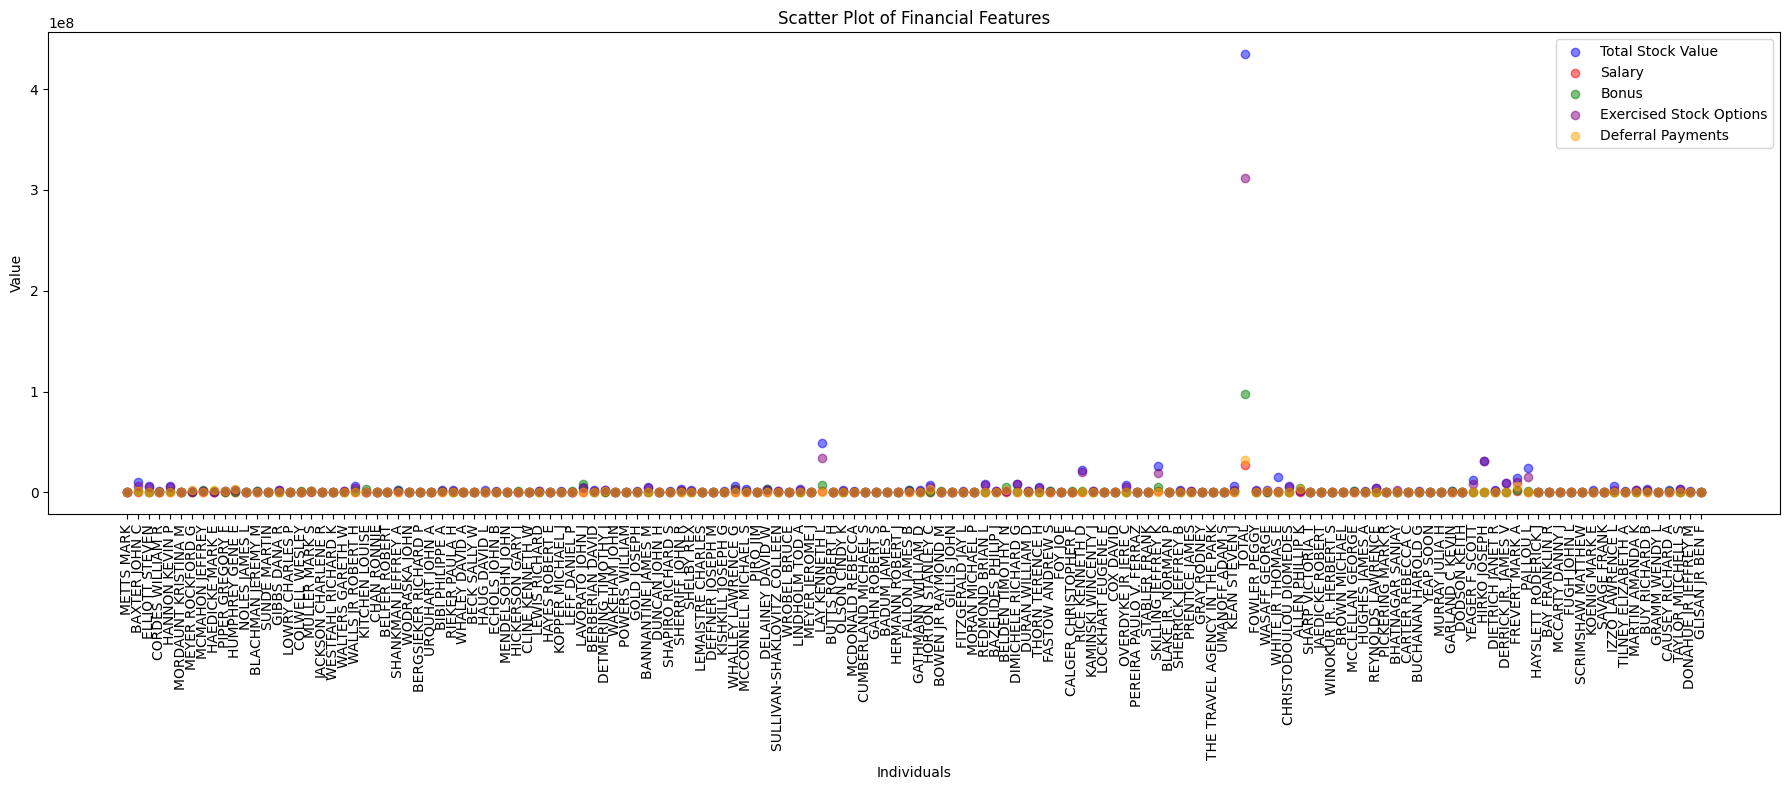

In [2]:
with open("../final_project/final_project_dataset_unix.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)
# load data into dataframe
enron_df = pd.DataFrame.from_dict(data_dict, orient = 'index')
# convert 'NaN' to NaN
cols_to_replace = enron_df.columns.difference(['email_address'])
enron_df[cols_to_replace] = enron_df[cols_to_replace].replace("NaN", np.nan)
# convert numeric values to numeric types
enron_df[cols_to_replace] = enron_df[cols_to_replace].apply(pd.to_numeric)
# fill numeric value to NaN fields
enron_df = enron_df.fillna(0)

plt.figure(figsize=(18, 8))
plt.scatter(enron_df.index, enron_df['total_stock_value'], label='Total Stock Value', color='blue', alpha=0.5)
plt.scatter(enron_df.index, enron_df['salary'], label='Salary', color='red', alpha=0.5)
plt.scatter(enron_df.index, enron_df['bonus'], label='Bonus', color='green', alpha=0.5)
plt.scatter(enron_df.index, enron_df['exercised_stock_options'], label='Exercised Stock Options', color='purple', alpha=0.5)
plt.scatter(enron_df.index, enron_df['deferral_payments'], label='Deferral Payments', color='orange', alpha=0.5)

# Rotate x-axis labels vertically
plt.xticks(rotation=90)

plt.xlabel("Individuals")
plt.ylabel("Value")
plt.title("Scatter Plot of Financial Features")
plt.legend()
plt.tight_layout()  # Adjust layout to fit rotated labels
plt.show()

## Remove Outliers
From the graph its clear that I should remove 'TOTAL'

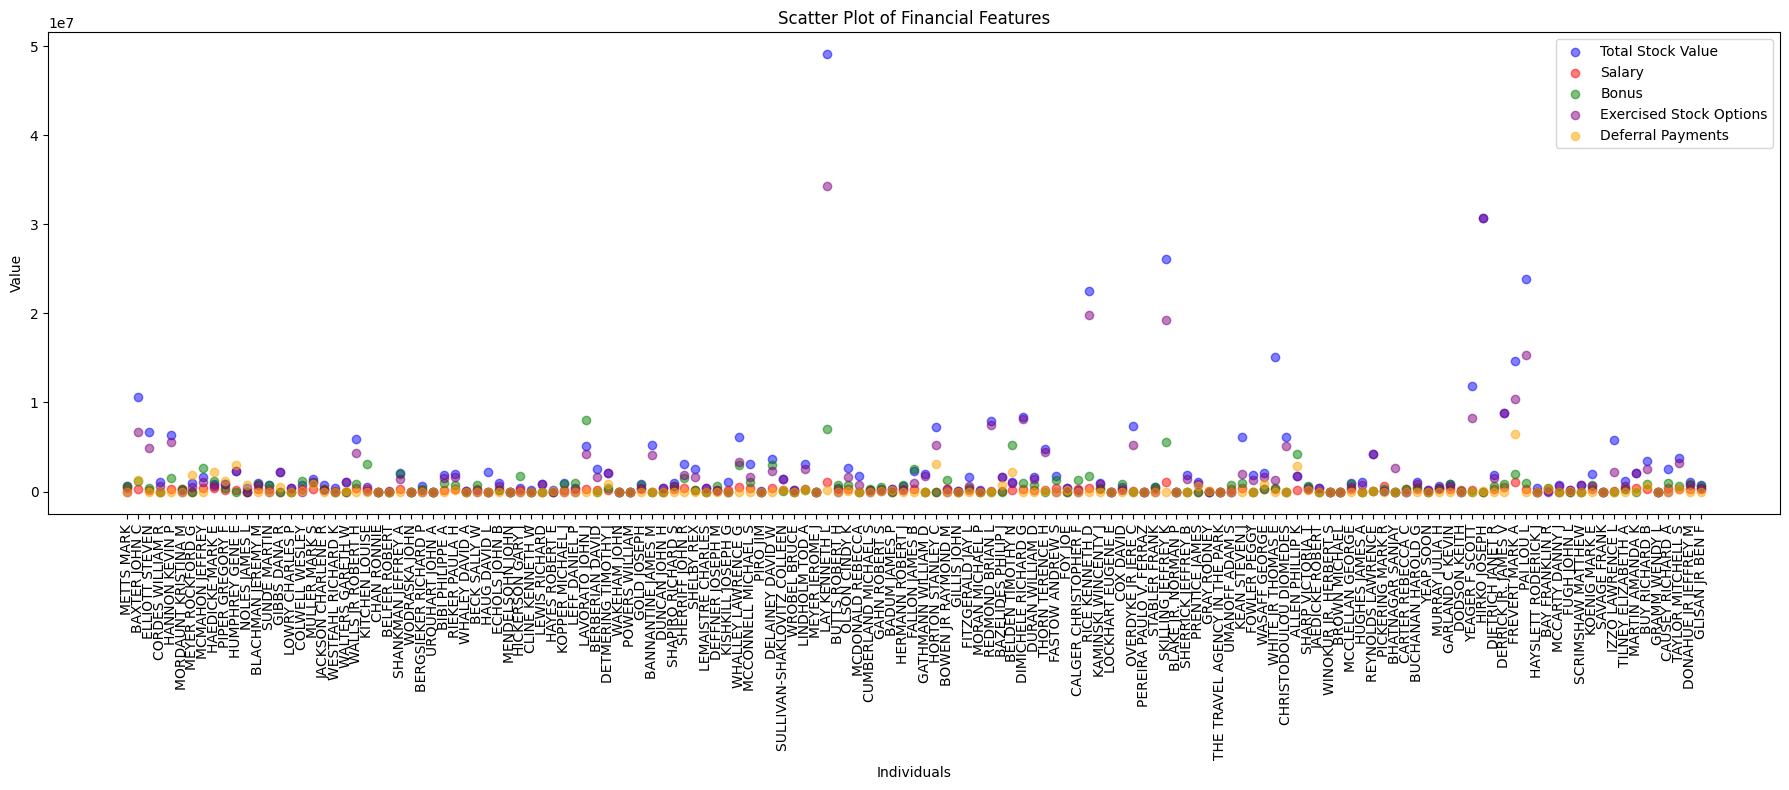

In [3]:
# print rows in my dataset
enron_df = enron_df.drop(['TOTAL'])
plt.figure(figsize=(18, 8))
plt.scatter(enron_df.index, enron_df['total_stock_value'], label='Total Stock Value', color='blue', alpha=0.5)
plt.scatter(enron_df.index, enron_df['salary'], label='Salary', color='red', alpha=0.5)
plt.scatter(enron_df.index, enron_df['bonus'], label='Bonus', color='green', alpha=0.5)
plt.scatter(enron_df.index, enron_df['exercised_stock_options'], label='Exercised Stock Options', color='purple', alpha=0.5)
plt.scatter(enron_df.index, enron_df['deferral_payments'], label='Deferral Payments', color='orange', alpha=0.5)

# Rotate x-axis labels vertically
plt.xticks(rotation=90)

plt.xlabel("Individuals")
plt.ylabel("Value")
plt.title("Scatter Plot of Financial Features")
plt.legend()
plt.tight_layout()  # Adjust layout to fit rotated labels
plt.show()

## Feature Analysis
### Random Forest

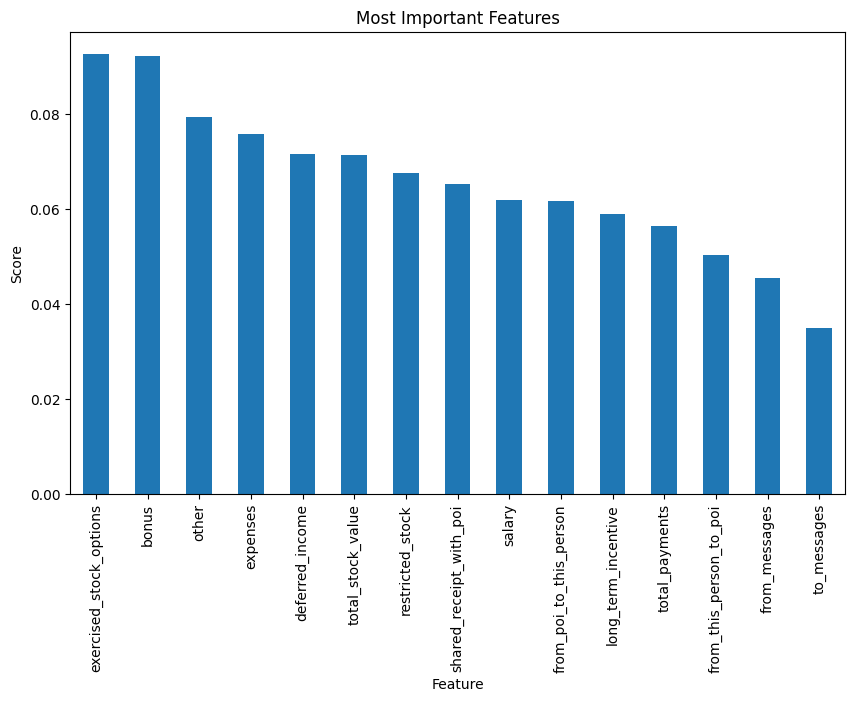

exercised_stock_options    0.092577
bonus                      0.092191
other                      0.079296
expenses                   0.075734
deferred_income            0.071625
total_stock_value          0.071272
restricted_stock           0.067587
shared_receipt_with_poi    0.065309
salary                     0.062001
from_poi_to_this_person    0.061621
long_term_incentive        0.058998
total_payments             0.056370
from_this_person_to_poi    0.050390
from_messages              0.045587
to_messages                0.034980
dtype: float64


In [4]:
from sklearn.ensemble import RandomForestClassifier

X = enron_df.drop(columns=['poi','email_address']) # remove non-numeric cols and poi
y = (enron_df['poi'] == 1).astype(int)

model = RandomForestClassifier()
model.fit(X, y)
# Sort feature importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot top features
plt.figure(figsize=(10, 6))
feature_importance[:15].plot(kind='bar')
plt.title("Most Important Features")
plt.xlabel("Feature")
plt.ylabel("Score")
plt.show()
print(feature_importance[:15])

Split dataset

In [5]:
### Extract features and labels from dataset for local testing

features_list = ['poi',  
    "exercised_stock_options",
    "total_stock_value",
    "bonus",
    "salary",
    "long_term_incentive",
    "restricted_stock",
    "deferred_income"]

data = featureFormat(data_dict, features_list, sort_keys = True)
data_dict.pop("TOTAL",0)
my_dataset = data_dict
labels, features = targetFeatureSplit(data)
# Convert lists to NumPy arrays
features = np.array(features)
labels = np.array(labels)


In [6]:
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

### Try Naive Bayes

In [7]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(features_train, labels_train)

predictions = clf.predict(features_test)
print("ACCURACY : ", accuracy_score(labels_test, predictions))
print(classification_report(labels_test, predictions))

ACCURACY :  0.11904761904761904
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        36
         1.0       0.12      0.83      0.21         6

    accuracy                           0.12        42
   macro avg       0.06      0.42      0.11        42
weighted avg       0.02      0.12      0.03        42



### Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
clf = RandomForestClassifier()
clf.fit(features_train, labels_train)
predictions = clf.predict(features_test)
print("ACCURACY : ", accuracy_score(labels_test, predictions))
print(classification_report(labels_test, predictions))

ACCURACY :  0.8571428571428571
              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92        36
         1.0       0.50      0.17      0.25         6

    accuracy                           0.86        42
   macro avg       0.69      0.57      0.59        42
weighted avg       0.82      0.86      0.83        42



### GRID SEARCH

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier


base_clf = DecisionTreeClassifier()
param_grid = {
    "n_estimators": [50, 100, 200],  
    "learning_rate": [0.01, 0.1, 1],  
    "estimator__max_depth": [1, 2, 3, 5]
}

clf = AdaBoostClassifier(estimator=base_clf, random_state=42,algorithm='SAMME')


grid_search = GridSearchCV(clf, param_grid, scoring="recall", cv=5)


grid_search.fit(features_train, labels_train)


best_model = grid_search.best_estimator_


predictions = best_model.predict(features_test)

print(" Best Parameters:", grid_search.best_params_)
print("Classification Report:")
print(classification_report(labels_test, predictions))

 Best Parameters: {'estimator__max_depth': 5, 'learning_rate': 0.01, 'n_estimators': 50}
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.97      0.93        36
         1.0       0.67      0.33      0.44         6

    accuracy                           0.88        42
   macro avg       0.78      0.65      0.69        42
weighted avg       0.86      0.88      0.86        42



C:\Users\danli\anaconda3\envs\ctu_urob\Lib\site-packages\numpy\ma\core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


# SVM


In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline as ImbPipeline 
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

pipeline = ImbPipeline([
    ("smote", SMOTE(sampling_strategy=0.7, random_state=42)),
    ("scaler", StandardScaler()),  # preprocess data
    ("svm", SVC(probability=False, random_state=42))  # SVM model
])

param_grid_svm = {
    "svm__C": [0.1, 1, 10], 
    "svm__kernel": ["rbf", "linear"],
    "svm__gamma": ["scale", 0.01, 0.1, 1],
}


grid_search_svm = GridSearchCV(pipeline, param_grid_svm, scoring="recall", cv=5, n_jobs=-1)

grid_search_svm.fit(features_train, labels_train)


best_svm = grid_search_svm.best_estimator_


predictions_svm = best_svm.predict(features_test)

print("Best Parameters for SVM:", grid_search_svm.best_params_)
print("Classification Report (SVM):")
print(classification_report(labels_test, predictions_svm))



Best Parameters for SVM: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Classification Report (SVM):
              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93        36
         1.0       0.60      0.50      0.55         6

    accuracy                           0.88        42
   macro avg       0.76      0.72      0.74        42
weighted avg       0.87      0.88      0.88        42



In [11]:
from tester import dump_classifier_and_data
dump_classifier_and_data(best_svm,my_dataset,features)